# 季節自己回帰和分移動平均 (Seasonal ARIMA) モデル

## 理論
- ARIMAモデルに周期性（季節性）を取り入れたモデル（ARIMAモデルでは季節性を表現できない）
- 時系列方向・周期方向それぞれにARIMAモデルを適用
    - 次数は全部で7つ：時系列方向の次数 $(p,d,q)$、周期方向の次数 $(P,D,Q)$、周期 $s$
- 季節性のあるデータは非定常（期待値が時変）
    - 季節階差により定常に
- 季節階差をARMAモデルで表現


In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO
# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

In [3]:
# Dataset
wpi1 = requests.get('https://www.stata-press.com/data/r12/wpi1.dta').content
data = pd.read_stata(BytesIO(wpi1))
data.index = data.t
# Set the frequency
data.index.freq="QS-OCT"

# Fit the model
mod = sm.tsa.statespace.SARIMAX(data['wpi'], trend='c', order=(1,1,1))
res = mod.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                    wpi   No. Observations:                  124
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -135.351
Date:                Tue, 09 Mar 2021   AIC                            278.703
Time:                        13:15:54   BIC                            289.951
Sample:                    01-01-1960   HQIC                           283.272
                         - 10-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0943      0.068      1.389      0.165      -0.039       0.227
ar.L1          0.8742      0.055     16.028      0.000       0.767       0.981
ma.L1         -0.4120      0.100     -4.119      0.0

In [4]:
# Dataset
data = pd.read_stata(BytesIO(wpi1))
data.index = data.t
data.index.freq="QS-OCT"

data['ln_wpi'] = np.log(data['wpi'])
data['D.ln_wpi'] = data['ln_wpi'].diff()

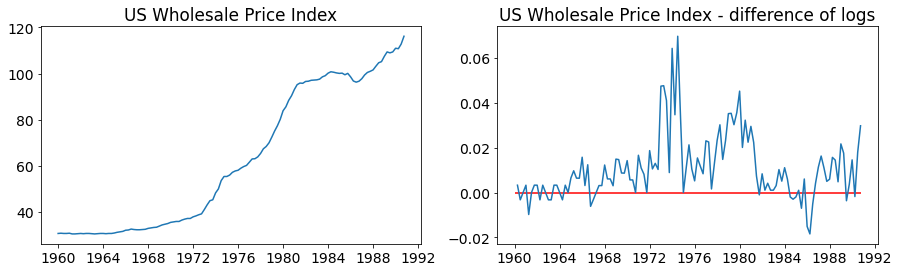

In [5]:
# Graph data
fig, axes = plt.subplots(1, 2, figsize=(15,4))

# Levels
axes[0].plot(data.index._mpl_repr(), data['wpi'], '-')
axes[0].set(title='US Wholesale Price Index')

# Log difference
axes[1].plot(data.index._mpl_repr(), data['D.ln_wpi'], '-')
axes[1].hlines(0, data.index[0], data.index[-1], 'r')
axes[1].set(title='US Wholesale Price Index - difference of logs');

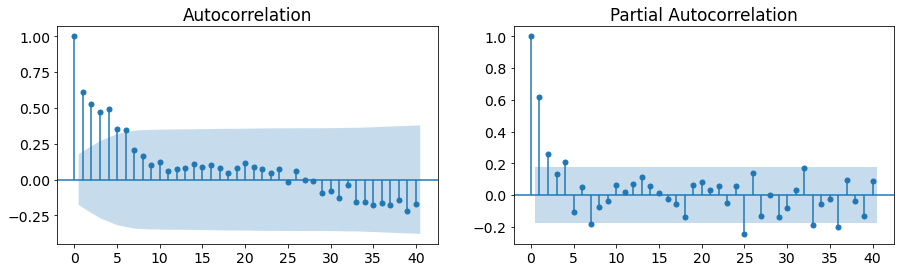

In [6]:
# Graph data
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(data.iloc[1:]['D.ln_wpi'], lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(data.iloc[1:]['D.ln_wpi'], lags=40, ax=axes[1])

In [7]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(data['ln_wpi'], trend='c', order=(1,1,(1,0,0,1)))
res = mod.fit(disp=False)
print(res.summary())

                                 SARIMAX Results                                 
Dep. Variable:                    ln_wpi   No. Observations:                  124
Model:             SARIMAX(1, 1, [1, 4])   Log Likelihood                 386.034
Date:                   Tue, 09 Mar 2021   AIC                           -762.067
Time:                           13:24:12   BIC                           -748.006
Sample:                       01-01-1960   HQIC                          -756.356
                            - 10-01-1990                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0024      0.002      1.484      0.138      -0.001       0.006
ar.L1          0.7807      0.094      8.263      0.000       0.595       0.966
ma.L1         -0.3992      0

In [8]:
# Dataset
air2 = requests.get('https://www.stata-press.com/data/r12/air2.dta').content
data = pd.read_stata(BytesIO(air2))
data.index = pd.date_range(start=datetime(data.time[0], 1, 1), periods=len(data), freq='MS')
data['lnair'] = np.log(data['air'])

# Fit the model
mod = sm.tsa.statespace.SARIMAX(data['lnair'], order=(2,1,0), seasonal_order=(1,1,0,12), simple_differencing=True)
res = mod.fit(disp=False)
print(res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       D.DS12.lnair   No. Observations:                  131
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 12)   Log Likelihood                 240.821
Date:                            Tue, 09 Mar 2021   AIC                           -473.643
Time:                                    13:24:25   BIC                           -462.142
Sample:                                02-01-1950   HQIC                          -468.970
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4057      0.080     -5.045      0.000      -0.563      -0.248
ar.L2         -0.0799      0.099   

<ipython-input-8-055d8479c397>:4: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  data.index = pd.date_range(start=datetime(data.time[0], 1, 1), periods=len(data), freq='MS')


In [9]:
# Dataset
friedman2 = requests.get('https://www.stata-press.com/data/r12/friedman2.dta').content
data = pd.read_stata(BytesIO(friedman2))
data.index = data.time
data.index.freq = "QS-OCT"

# Variables
endog = data.loc['1959':'1981', 'consump']
exog = sm.add_constant(data.loc['1959':'1981', 'm2'])

# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog, exog, order=(1,0,1))
res = mod.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                consump   No. Observations:                   92
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -340.508
Date:                Tue, 09 Mar 2021   AIC                            691.015
Time:                        13:24:39   BIC                            703.624
Sample:                    01-01-1959   HQIC                           696.105
                         - 10-01-1981                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -36.0607     56.643     -0.637      0.524    -147.078      74.957
m2             1.1220      0.036     30.825      0.000       1.051       1.193
ar.L1          0.9348      0.041     22.717      0.0

In [10]:
# Dataset
raw = pd.read_stata(BytesIO(friedman2))
raw.index = raw.time
raw.index.freq = "QS-OCT"
data = raw.loc[:'1981']

# Variables
endog = data.loc['1959':, 'consump']
exog = sm.add_constant(data.loc['1959':, 'm2'])
nobs = endog.shape[0]

# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog.loc[:'1978-01-01'], exog=exog.loc[:'1978-01-01'], order=(1,0,1))
fit_res = mod.fit(disp=False, maxiter=250)
print(fit_res.summary())

                               SARIMAX Results                                
Dep. Variable:                consump   No. Observations:                   77
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -243.316
Date:                Tue, 09 Mar 2021   AIC                            496.633
Time:                        13:24:49   BIC                            508.352
Sample:                    01-01-1959   HQIC                           501.320
                         - 01-01-1978                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6770     18.491      0.037      0.971     -35.564      36.918
m2             1.0379      0.021     50.331      0.000       0.997       1.078
ar.L1          0.8775      0.059     14.859      0.0

/Users/t-hayasaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
